In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
try:
    import torchvision
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchvision"])  
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [ ]:
import os
import zipfile

from pathlib import Path
import torch
import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [ ]:
dir_modular = Path("going_modular/")
dir_modular.mkdir(parents=True, exist_ok=True)

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
%%writefile going_modular/data_loader.py

import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Constants
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

def data_loader(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int = BATCH_SIZE,
    num_workers: int = NUM_WORKERS
):
    # Load datasets
    train_data = datasets.ImageFolder(root=train_dir, transform=transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create DataLoaders
    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    # Extract class names
    class_names = train_data.classes

    return train_dataloader, test_dataloader, class_names


Overwriting going_modular/data_loader.py


In [ ]:
%%writefile going_modular/model_builder.py
import torch
from torch import nn

class TinyVGGV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_size: int= 64) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
            nn.MaxPool2d(2)
        )

        # Dummy forward pass to calculate flatten size
        with torch.no_grad():
            dummy_input = torch.randn(1, input_shape, image_size, image_size)
            out = self.block1(dummy_input)
            out = self.block2(out)
            flatten_units = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_units, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x



Overwriting going_modular/model_builder.py


In [ ]:
%%writefile going_modular/engine.py

import torch
from torch import nn
from tqdm.auto import tqdm

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)  # Corrected denominator
    return train_loss, train_acc


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module):
    model.eval()
    test_loss, test_acc = 0.0, 0.0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item()

    test_loss /= len(dataloader)
    test_acc /= len(dataloader.dataset)  # Corrected denominator
    return test_loss, test_acc


def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device = device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


Overwriting going_modular/engine.py


In [ ]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting going_modular/utils.py


In [ ]:
import torchvision
weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weight).to(device=device)

In [ ]:
auto_transforms = weight.transforms()

In [ ]:
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
for params in model_0.parameters():
  params.requires_grad = False

In [ ]:
from going_modular.data_loader import data_loader
train_dataloader, test_dataloader, class_names = data_loader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32,
)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
model_0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)


In [ ]:
summary(model=model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
EPOCHS_RES=5

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
from going_modular.engine import train
start_time = timer()

model_0_results = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=EPOCHS_RES,
                device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.0973, Train Acc: 0.4311 | Test Loss: 1.0032, Test Acc: 0.4933
Epoch 2/5 | Train Loss: 0.8661, Train Acc: 0.7911 | Test Loss: 0.8480, Test Acc: 0.7733
Epoch 3/5 | Train Loss: 0.7693, Train Acc: 0.7867 | Test Loss: 0.7775, Test Acc: 0.7600
Epoch 4/5 | Train Loss: 0.7186, Train Acc: 0.8667 | Test Loss: 0.6742, Test Acc: 0.8000
Epoch 5/5 | Train Loss: 0.6244, Train Acc: 0.9111 | Test Loss: 0.6581, Test Acc: 0.8400
Total training time: 11.778 seconds


In [ ]:
del model_0, optimizer
torch.cuda.empty_cache()


In [ ]:
weight = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b1(weights=weight).to(device=device)

In [ ]:
auto_transforms = weight.transforms()

for params in model_1.parameters():
  params.requires_grad = False

In [ ]:
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [ ]:
train_dataloader, test_dataloader, class_names = data_loader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32,
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

model_1_results = train(model=model_1,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=EPOCHS_RES,
                device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.0677, Train Acc: 0.6044 | Test Loss: 0.9885, Test Acc: 0.7200
Epoch 2/5 | Train Loss: 0.9465, Train Acc: 0.8711 | Test Loss: 0.9109, Test Acc: 0.8400
Epoch 3/5 | Train Loss: 0.8671, Train Acc: 0.8933 | Test Loss: 0.8314, Test Acc: 0.9067
Epoch 4/5 | Train Loss: 0.7785, Train Acc: 0.9467 | Test Loss: 0.7619, Test Acc: 0.9200
Epoch 5/5 | Train Loss: 0.7467, Train Acc: 0.9333 | Test Loss: 0.7323, Test Acc: 0.8933
Total training time: 12.029 seconds


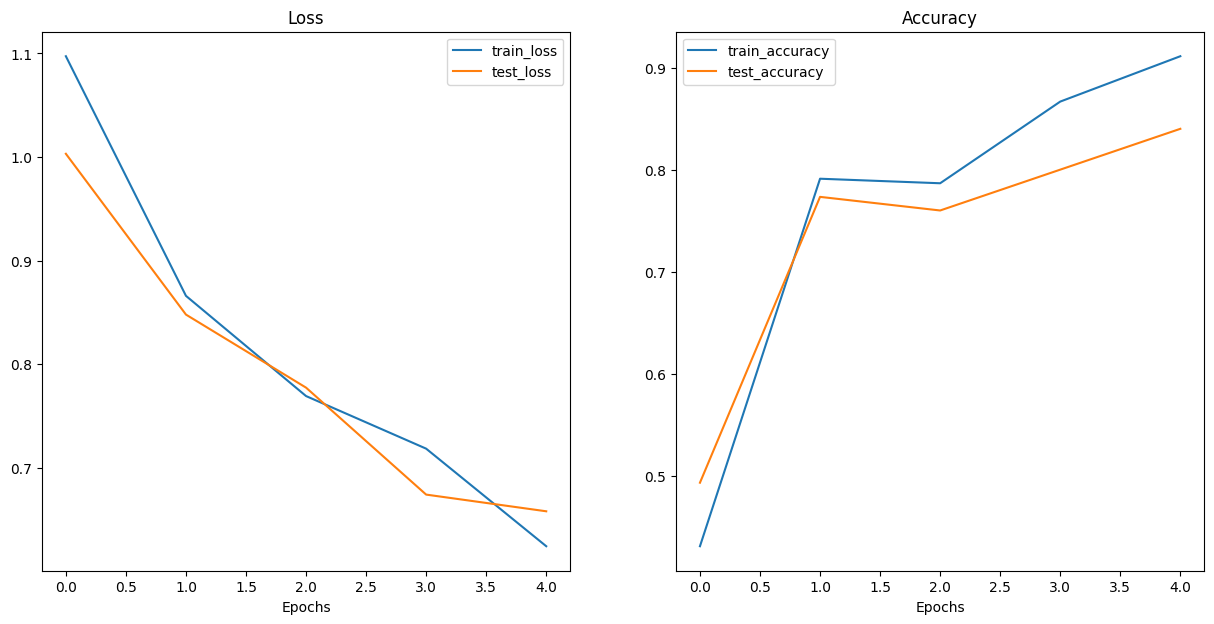

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_0_results)

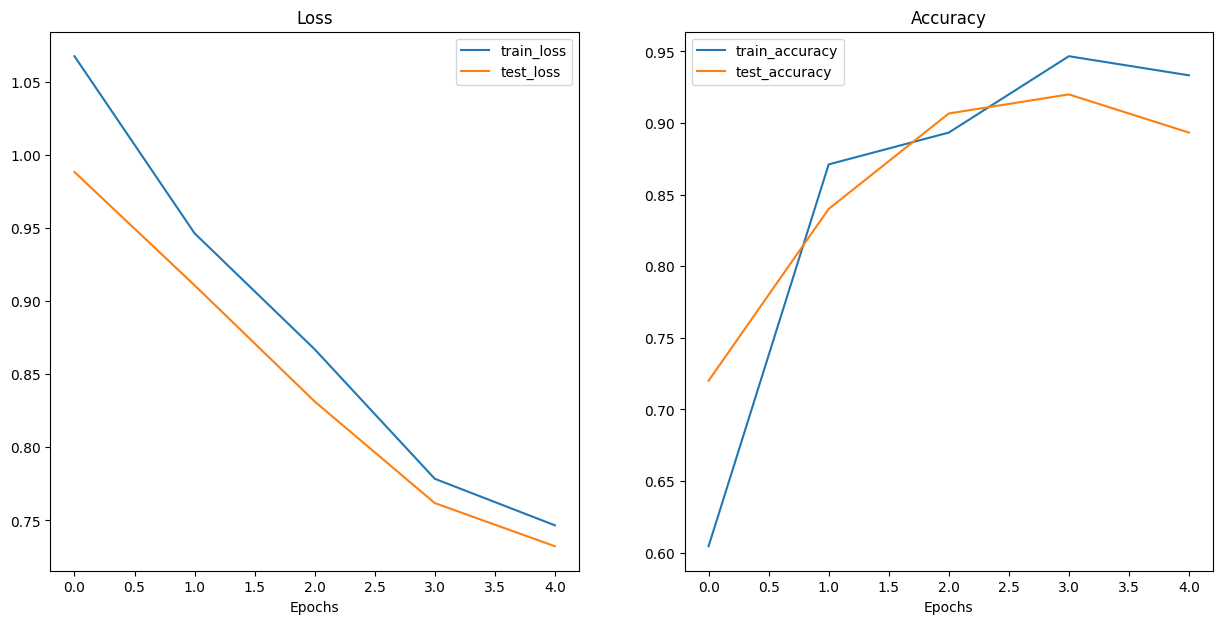

In [ ]:
plot_loss_curves(model_1_results)